In [1]:
# importing required libraries 
import tensorflow as tf 
from tensorflow.keras import Model, Input 
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, BatchNormalization, Dropout, Rescaling
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import os 
from google_drive_downloader import GoogleDriveDownloader as gdd 
import shutil

# setting random seeds 
np.random.seed(0)
tf.random.set_seed(0)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

### Post downloading and extracting the downloaded zip files, following folders will be created . However, these folders are reorganized to a more consistent folder structure 
1. images_without_poachers : contains train, val, test 'images without poachers'
2. split_dataset : contains train, val 'images with poachers'
3. merged_datasets : contains test 'images with poachers'
Folder names are same as in the zipped file. (However, it may be good to use descriptive names in future revisions of the dataset)

### After folder reorganization 
dataset_dat
- train 
  - poachers
  - no_poachers
- val 
  - poachers 
  - no_poachers
- test 
  - poachers 
  - no_poachers 


In [2]:
# downloading project zip file containing 'images without poachers' 
file_id = '1r1u4oB_e4QSeLHVRGKgPWonw6uorxUrk'
gdd.download_file_from_google_drive(file_id=file_id, dest_path = '/content/images_without_poachers.zip', unzip=True)


Unzipping...Done.


In [3]:
# downloading project zip files (training and validation images) containing 'images with poachers'
file_id = '1-3Gaaeq_BzCga9dVzIlK9cV-Zj1uy6-i'
gdd.download_file_from_google_drive(file_id=file_id, dest_path = '/content/dataset.zip', unzip=True) # this is actually the training and val dataset . zip filename used is same as in the shared google drive


Unzipping...Done.


In [4]:
# downloading project zip files (testing images) containing 'images with poachers'
file_id = '1zTCX81mrwULoziabsOcHMjntuQFFQDD0'
gdd.download_file_from_google_drive(file_id=file_id, dest_path = '/content/test_dataset.zip', unzip=True)  # this is actually the testing dataset. zip filename used is same as in the shared google drive


Unzipping...Done.


In [5]:
# defining various original folderpaths
orig_folderpath_train_poachers    = '/content/split_dataset/images/train/'
orig_folderpath_train_nopoachers  = '/content/images_without_poachers/train/'

orig_folderpath_val_poachers      = '/content/split_dataset/images/val/'
orig_folderpath_val_nopoachers    = '/content/images_without_poachers/val/'

orig_folderpath_test_poachers     = '/content/merged_datasets/test_dataset/images/'
orig_folderpath_test_nopoachers   = '/content/images_without_poachers/test/'

# printing stats on count of images 
print(len(os.listdir(orig_folderpath_train_poachers)), 'trainset poacher images' )
print(len(os.listdir(orig_folderpath_train_nopoachers)), 'trainset without poacher images')
print(len(os.listdir(orig_folderpath_val_poachers)), 'valset poacher images' )
print(len(os.listdir(orig_folderpath_val_nopoachers)), 'valset without poacher images')
print(len(os.listdir(orig_folderpath_test_poachers)), 'testset poacher images' )
print(len(os.listdir(orig_folderpath_test_nopoachers)), 'testset without poacher images')

13111 trainset poacher images
10841 trainset without poacher images
3278 valset poacher images
2711 valset without poacher images
1900 testset poacher images
940 testset without poacher images


In [6]:
# rearranging to a simpler and consistent directory organization 
dst_base_dir = '/content/dataset_dst/'

dst_folderpath_train_poachers    = os.path.join(dst_base_dir , 'train/poachers/')
dst_folderpath_train_nopoachers  = os.path.join(dst_base_dir , 'train/no_poachers/')

dst_folderpath_val_poachers    = os.path.join(dst_base_dir , 'val/poachers/')
dst_folderpath_val_nopoachers  = os.path.join(dst_base_dir , 'val/no_poachers/')

dst_folderpath_test_poachers    = os.path.join(dst_base_dir , 'test/poachers/')
dst_folderpath_test_nopoachers  = os.path.join(dst_base_dir , 'test/no_poachers/')

orig_dst_folderpaths = [  
                         ( orig_folderpath_train_poachers, dst_folderpath_train_poachers ) ,
                         ( orig_folderpath_train_nopoachers, dst_folderpath_train_nopoachers ) ,
                         ( orig_folderpath_val_poachers, dst_folderpath_val_poachers ) ,
                         ( orig_folderpath_val_nopoachers, dst_folderpath_val_nopoachers ) ,
                         ( orig_folderpath_test_poachers, dst_folderpath_test_poachers ) ,
                         ( orig_folderpath_test_nopoachers, dst_folderpath_test_nopoachers ) ,
                       ]

In [7]:
# moving from orig to dst folders 
for orig, dst in orig_dst_folderpaths  :
  if os.path.exists(orig) :
    shutil.move(orig, dst)


In [8]:
# removing older folders 
!rm -r '/content/split_dataset/'
!rm -r '/content/merged_datasets/'
!rm -r '/content/images_without_poachers/'


In [9]:
# verifying total number of files in dst_folderpaths (with previously printed counts before moving folders)
print(len(os.listdir(dst_folderpath_train_poachers)), 'trainset poacher images' )
print(len(os.listdir(dst_folderpath_train_nopoachers)), 'trainset without poacher images')
print(len(os.listdir(dst_folderpath_val_poachers)), 'valset poacher images' )
print(len(os.listdir(dst_folderpath_val_nopoachers)), 'valset without poacher images')
print(len(os.listdir(dst_folderpath_test_poachers)), 'testset poacher images' )
print(len(os.listdir(dst_folderpath_test_nopoachers)), 'testset without poacher images')

13111 trainset poacher images
10841 trainset without poacher images
3278 valset poacher images
2711 valset without poacher images
1900 testset poacher images
940 testset without poacher images


### Defining train, val and test set generators 

In [10]:
image_size = (256, 256)
batch_size = 64
dst_folderpath_train = '/content/dataset_dst/train/'
dst_folderpath_val   = '/content/dataset_dst/val/'
dst_folderpath_test  = '/content/dataset_dst/test/'

print('train_ds')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dst_folderpath_train,
    image_size=image_size,
    batch_size=batch_size,
    color_mode = 'grayscale'
)

print('val_ds')
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dst_folderpath_val,
    image_size=image_size,
    batch_size=batch_size,
    color_mode = 'grayscale'
)

print('test_ds')
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dst_folderpath_test,
    image_size=image_size,
    batch_size=batch_size,
    color_mode = 'grayscale'
)

# buffered prefetching so we can yield data from disk without having I/O becoming blocking
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

train_ds
Found 23952 files belonging to 2 classes.
val_ds
Found 5989 files belonging to 2 classes.
test_ds
Found 2840 files belonging to 2 classes.


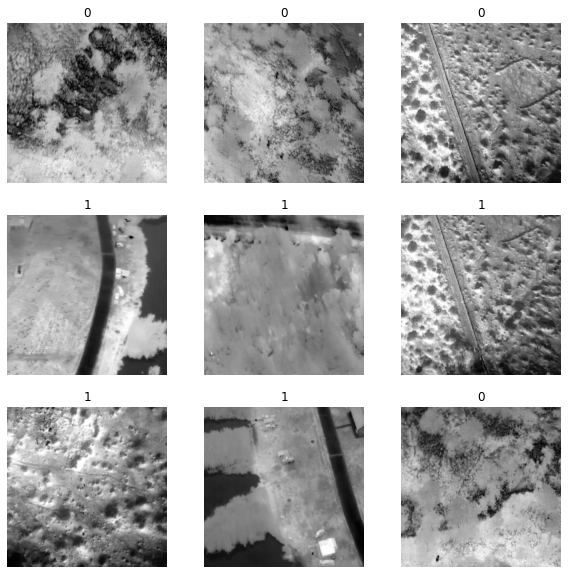

In [11]:
# visualizing the data 
# train 
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # images are eager tensors with 'float32' dtype and shape [64,256,256,1], labels are eager tensors with 'int32' dtype and shape (64,)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().squeeze().astype('uint8') 
        plt.imshow(img, cmap='gray')
        plt.title(int(labels[i]))
        plt.axis("off")

# as we can see in the plots, images with poachers are labelled as 1, images without poachers are labelled as 0

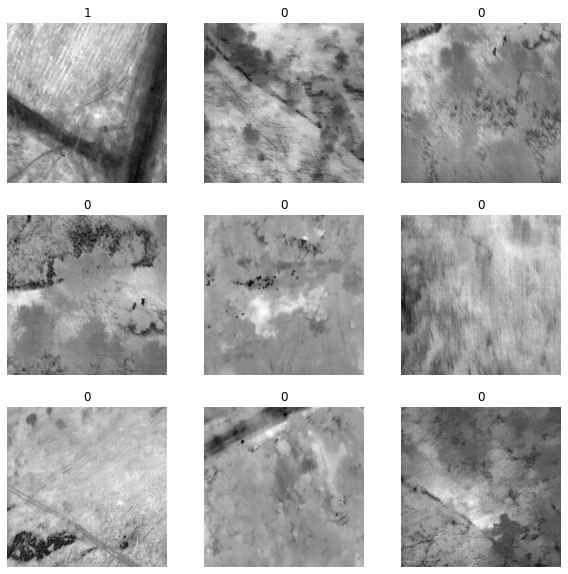

In [12]:
# visualizing the data 
# val 
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1): # images are eager tensors with 'float32' dtype and shape [64,256,256,1], labels are eager tensors with 'int32' dtype and shape (64,)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().squeeze().astype('uint8') 
        plt.imshow(img, cmap='gray')
        plt.title(int(labels[i]))
        plt.axis("off")

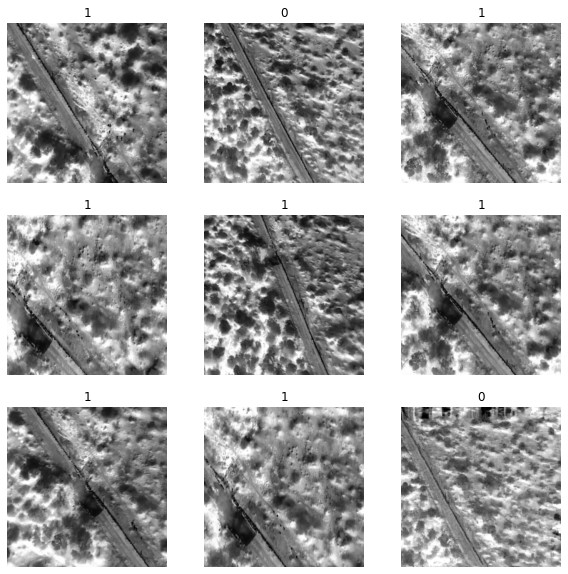

In [13]:
# visualizing the data 
# test 
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1): # images are eager tensors with 'float32' dtype and shape [64,256,256,1], labels are eager tensors with 'int32' dtype and shape (64,)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().squeeze().astype('uint8') 
        plt.imshow(img, cmap='gray')
        plt.title(int(labels[i]))
        plt.axis("off")

### Defining model architecture, optimizer settings, etc 

In [ ]:
# function for defining model architecture 
def make_model(input_shape):
    input = Input(shape=input_shape)
    # a minified version of VGGNet
    x = Rescaling(1.0 / 255)(input)
    x = Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2),  strides=(2,2))(x) 
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=(3,3), padding="valid", strides=(2,2) , activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=(3,3), padding="valid",  strides=(2,2) ,activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2),  strides=(2,2))(x) 
    x = Dropout(0.25)(x)
    x = Conv2D(128, kernel_size=(3,3), padding="valid",  strides=(2,2) , activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=(3,3), padding="valid",  strides=(2,2) , activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2),  strides=(2,2))(x) 
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(input, output)
    return model

# instantiating the model
model = make_model(input_shape= image_size + (1,) )
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 254, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 252, 252, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0     

In [ ]:
# compiling the model - setting loss function, metrics and optimizer , defining callbacks 
opt  = tf.keras.optimizers.Adam(learning_rate = 1e-3)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = ['accuracy']
model.compile(optimizer=opt, loss=loss, metrics=metrics)


### Training the model 

In [ ]:
checkpoint = ModelCheckpoint('best_model_minivgg.h5', 
                              monitor="val_accuracy", mode="max", 
                              save_weights_only=True, save_best_only=True, save_freq='epoch' , 
                              verbose=1 )
callbacks = [checkpoint]

num_epochs = 10
H = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds, callbacks = callbacks)

Epoch 1/10
375/375 [==============================] - 259s 580ms/step - loss: 0.5993 - accuracy: 0.7022 - val_loss: 2.3540 - val_accuracy: 0.4538

Epoch 00001: val_accuracy improved from -inf to 0.45383, saving model to best_model_minivgg.h5
Epoch 2/10
375/375 [==============================] - 217s 573ms/step - loss: 0.3768 - accuracy: 0.8350 - val_loss: 0.7240 - val_accuracy: 0.7023

Epoch 00002: val_accuracy improved from 0.45383 to 0.70229, saving model to best_model_minivgg.h5
Epoch 3/10
375/375 [==============================] - 218s 574ms/step - loss: 0.2706 - accuracy: 0.8934 - val_loss: 1.2970 - val_accuracy: 0.6757

Epoch 00003: val_accuracy did not improve from 0.70229
Epoch 4/10
375/375 [==============================] - 215s 565ms/step - loss: 0.2105 - accuracy: 0.9227 - val_loss: 0.8566 - val_accuracy: 0.7512

Epoch 00004: val_accuracy improved from 0.70229 to 0.75121, saving model to best_model_minivgg.h5
Epoch 5/10
375/375 [==============================] - 206s 546ms/s

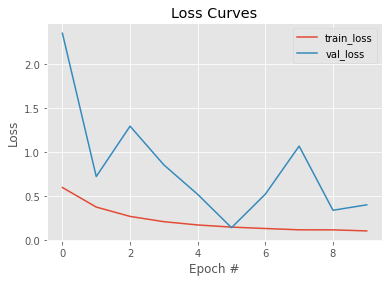

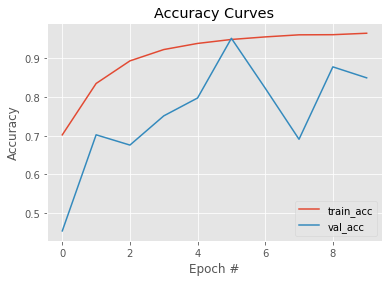

In [ ]:
# plotting loss and accuracy curves 
plt.style.use('ggplot')
# loss plots
plt.figure()
plt.plot(np.arange(num_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(num_epochs), H.history["val_loss"], label="val_loss")
plt.title("Loss Curves")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
# accuracy plots
plt.figure()
plt.plot(np.arange(num_epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(num_epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Accuracy Curves")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# evaluation on test set 
test_loss, test_accuracy = model.evaluate(test_ds)

45/45 [==============================] - 15s 270ms/step - loss: 2.0986 - accuracy: 0.4405


In [ ]:
# zip data for download
!zip -r /content/dataset_dst.zip /content/dataset_dst

Streaming output truncated to the last 5000 lines.
  adding: content/dataset_dst/val/no_poachers/videobh_2_frame_001677.PNG (deflated 0%)
  adding: content/dataset_dst/val/no_poachers/videobh_1_frame_004654.PNG (deflated 0%)
  adding: content/dataset_dst/val/no_poachers/videobh_3_frame_004653.PNG (deflated 0%)
  adding: content/dataset_dst/val/no_poachers/videobh_2_frame_001209.PNG (deflated 0%)
  adding: content/dataset_dst/val/no_poachers/videobh_2_frame_001275.PNG (deflated 0%)
  adding: content/dataset_dst/val/no_poachers/videobh_1_frame_002872.PNG (deflated 0%)
  adding: content/dataset_dst/val/no_poachers/videobh_2_frame_002777.PNG (deflated 0%)
  adding: content/dataset_dst/val/no_poachers/videobh_2_frame_002216.PNG (deflated 0%)
  adding: content/dataset_dst/val/no_poachers/videobh_3_frame_002923.PNG (deflated 0%)
  adding: content/dataset_dst/val/no_poachers/video53_2_frame_000039.PNG (deflated 1%)
  adding: content/dataset_dst/val/no_poachers/videobh_3_frame_004979.PNG (defla